# Titanic Predcition 

In [ ]:
import pandas as pd 
import seaborn as sns 
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly.figure_factory import create_distplot
import matplotlib.pyplot as plt
from pylab import *

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from pca import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from bioinfokit.analys import get_data
from bioinfokit.visuz import cluster

from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from category_encoders import TargetEncoder
import category_encoders as ce

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import plotly.io as pio


import plotly.graph_objects as go

from xgboost import plot_tree
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import ADASYN
from matplotlib import pyplot

import shap



from missingpy import MissForest

In [18]:
train = pd.read_csv("train (3).csv")

In [20]:
test = pd.read_csv("test (3).csv")

### Visualizing Misssing Data 

#### Train Data:

<AxesSubplot:>

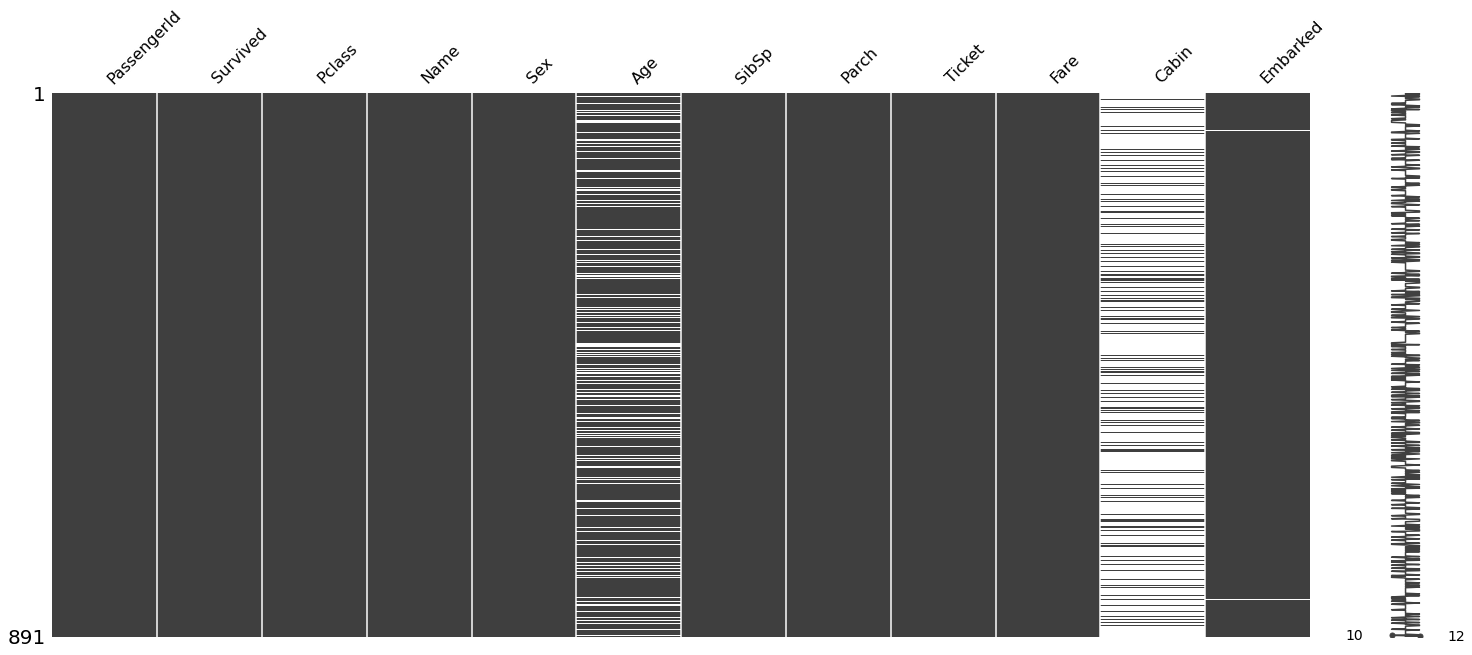

In [19]:
msno.matrix(train)

#### Train Data 

<AxesSubplot:>

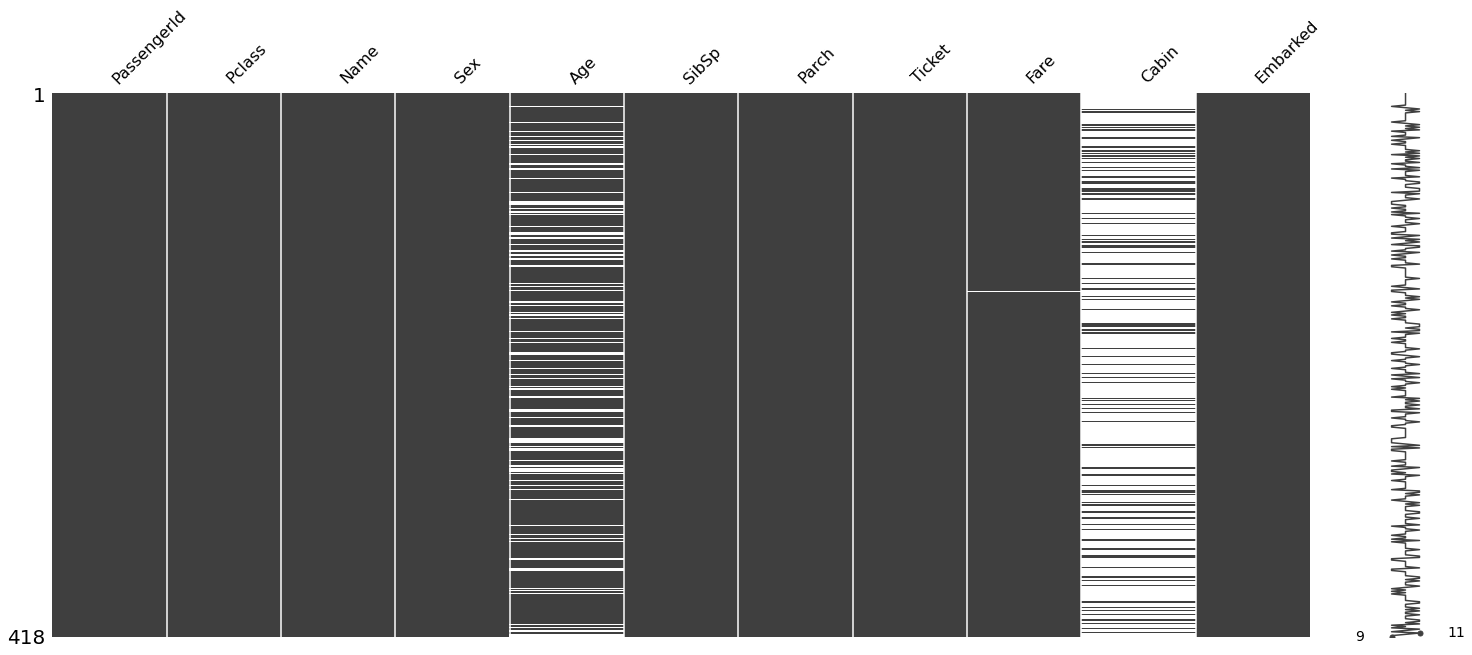

In [97]:
msno.matrix(test)

### Key Vairables 

survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	

Age	Age in years	

sibsp	# of siblings / spouses aboard the Titanic	

parch	# of parents / children aboard the Titanic	

ticket	Ticket number	

fare	Passenger fare	

cabin	Cabin number	

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [17]:
train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
pio.renderers.default='svg'
pio.renderers.default='browser'
px.histogram(train, x="Cabin")

## Missed Forest Imputation for Age 

The features which would be dropped for the first model are as follows :

1) PassengerId

2) Name 

3) Cabin - Cabin variable as we can see has a lot of missing rows and moreover, setting up a missed forest to or other imputation method does not help us in predcting the cabin number of a person 

4) Ticket Number 



In [35]:
train_missforest = train.drop(["PassengerId","Name", "Cabin","Ticket"], axis = 1)

In [39]:
train_missforest.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

<AxesSubplot:xlabel='Survived', ylabel='count'>

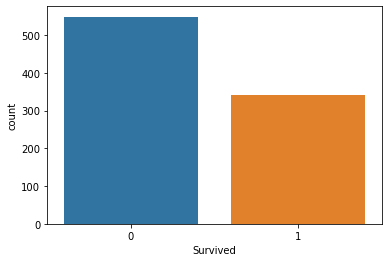

In [52]:
sns.countplot(x ="Survived",data = train)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

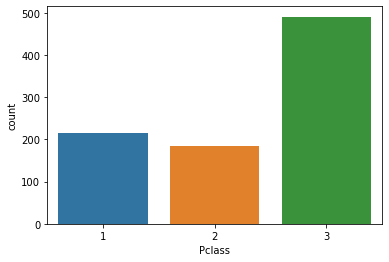

In [29]:
sns.countplot(x ="Pclass",data = train)

<AxesSubplot:xlabel='Sex', ylabel='count'>

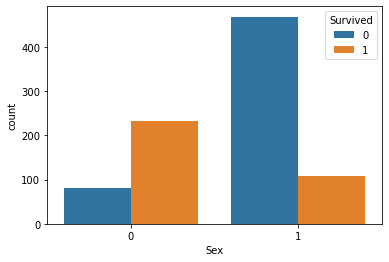

In [236]:
sns.countplot(x ="Sex",data = train_missforest , hue = "Survived")

<AxesSubplot:xlabel='SibSp', ylabel='count'>

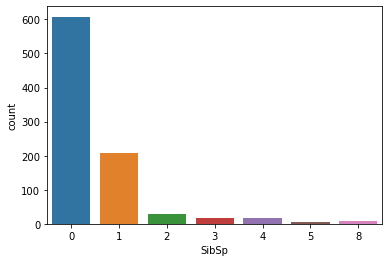

In [32]:
sns.countplot(x ="SibSp",data = train)

<AxesSubplot:xlabel='Parch', ylabel='count'>

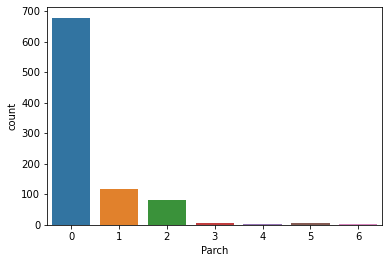

In [33]:
sns.countplot(x ="Parch",data = train)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

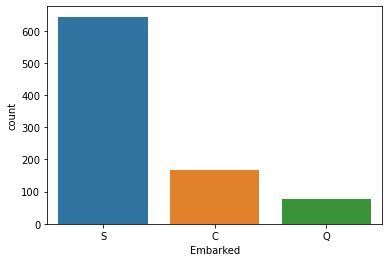

In [38]:
sns.countplot(x ="Embarked",data = train)

#### Evidence of Weight encoding for Embarked with respect to Survival 

In [45]:
columns = ["Embarked"]
woe_encoder = ce.WOEEncoder(cols=columns)
woe = woe_encoder.fit(train_missforest[columns], train_missforest['Survived'])
woe_encoded_train = woe_encoder.fit_transform(train_missforest[columns],train_missforest['Survived']).add_suffix('_woe')

In [46]:
train_missforest = train_missforest.join(woe_encoded_train)

In [47]:
train_missforest

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
0,0,3,male,22.0,1,0,7.2500,S,-0.203535
1,1,1,female,38.0,1,0,71.2833,C,0.683655
2,1,3,female,26.0,0,0,7.9250,S,-0.203535
3,1,1,female,35.0,1,0,53.1000,S,-0.203535
4,0,3,male,35.0,0,0,8.0500,S,-0.203535
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,-0.203535
887,1,1,female,19.0,0,0,30.0000,S,-0.203535
888,0,3,female,NaN,1,2,23.4500,S,-0.203535
889,1,1,male,26.0,0,0,30.0000,C,0.683655


In [50]:
train_missforest.groupby("Embarked").mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_woe
Embarked,,,,,,,
C,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144,0.683655
Q,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030,0.033879
S,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812,-0.203535


These values would be used just for Imputation method 

In [53]:
def Sex(value):
    if value == "male":
        return 1 
    else:
        return 0 
    
train_missforest["Sex"] = train_missforest["Sex"].apply(Sex)

<AxesSubplot:>

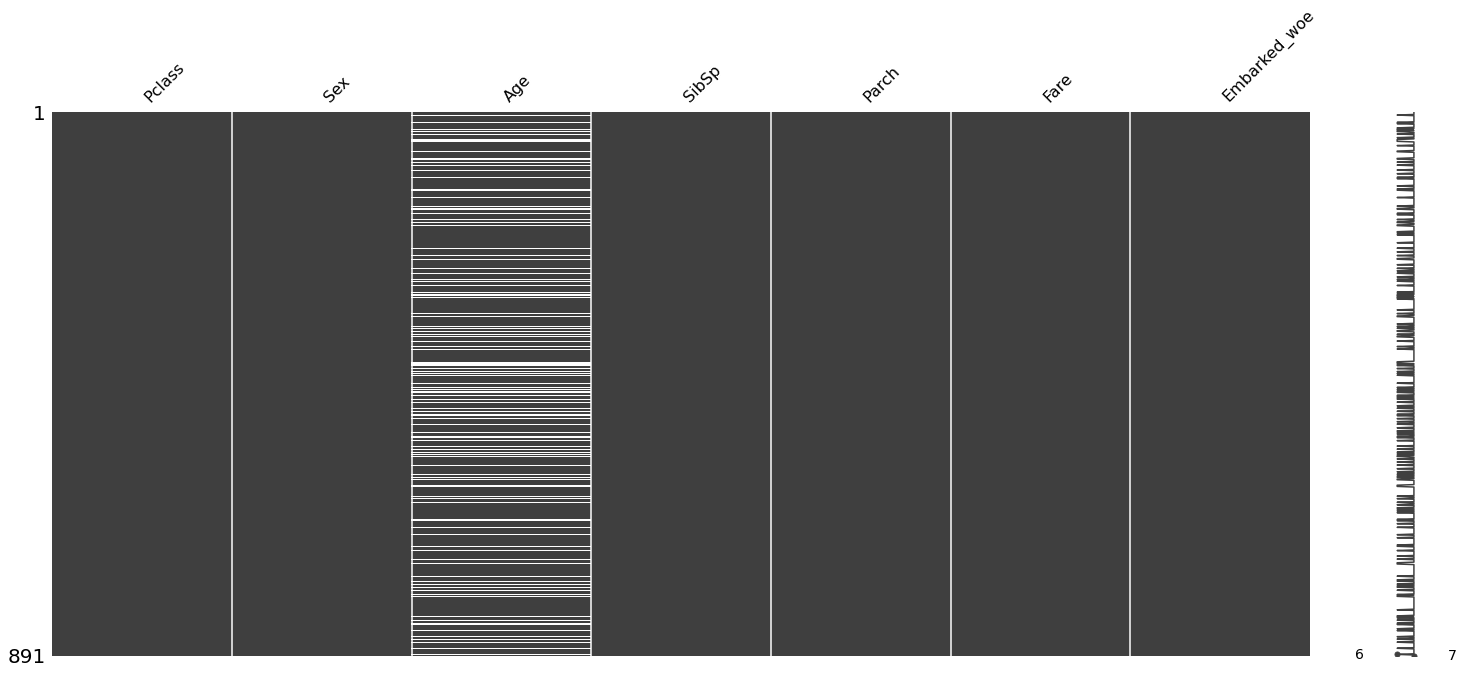

In [57]:
train_missforest_f = train_missforest.drop(["Embarked","Survived"], axis = 1)
msno.matrix(train_missforest_f)

In [65]:
train_missforest_f

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
0,3,1,22.0,1,0,7.2500,-0.203535
1,1,0,38.0,1,0,71.2833,0.683655
2,3,0,26.0,0,0,7.9250,-0.203535
3,1,0,35.0,1,0,53.1000,-0.203535
4,3,1,35.0,0,0,8.0500,-0.203535
...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,-0.203535
887,1,0,19.0,0,0,30.0000,-0.203535
888,3,0,NaN,1,2,23.4500,-0.203535
889,1,1,26.0,0,0,30.0000,0.683655


In [60]:
imputer = MissForest()
fill = imputer.fit_transform(train_missforest_f,cat_vars = [0,1,3,4,6])

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



Iteration: 0
Iteration: 1
Iteration: 2


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars



In [63]:
data_f = pd.DataFrame(fill, columns =["PClass","Sex","Age","SibSp","Parch","Fare","Embarked_woe"])

In [64]:
data_f

,PClass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
0,3.0,1.0,22.000000,1.0,0.0,7.2500,-0.203535
1,1.0,0.0,38.000000,1.0,0.0,71.2833,0.683655
2,3.0,0.0,26.000000,0.0,0.0,7.9250,-0.203535
3,1.0,0.0,35.000000,1.0,0.0,53.1000,-0.203535
4,3.0,1.0,35.000000,0.0,0.0,8.0500,-0.203535
...,...,...,...,...,...,...,...
886,2.0,1.0,27.000000,0.0,0.0,13.0000,-0.203535
887,1.0,0.0,19.000000,0.0,0.0,30.0000,-0.203535
888,3.0,0.0,16.268333,1.0,2.0,23.4500,-0.203535
889,1.0,1.0,26.000000,0.0,0.0,30.0000,0.683655


<AxesSubplot:>

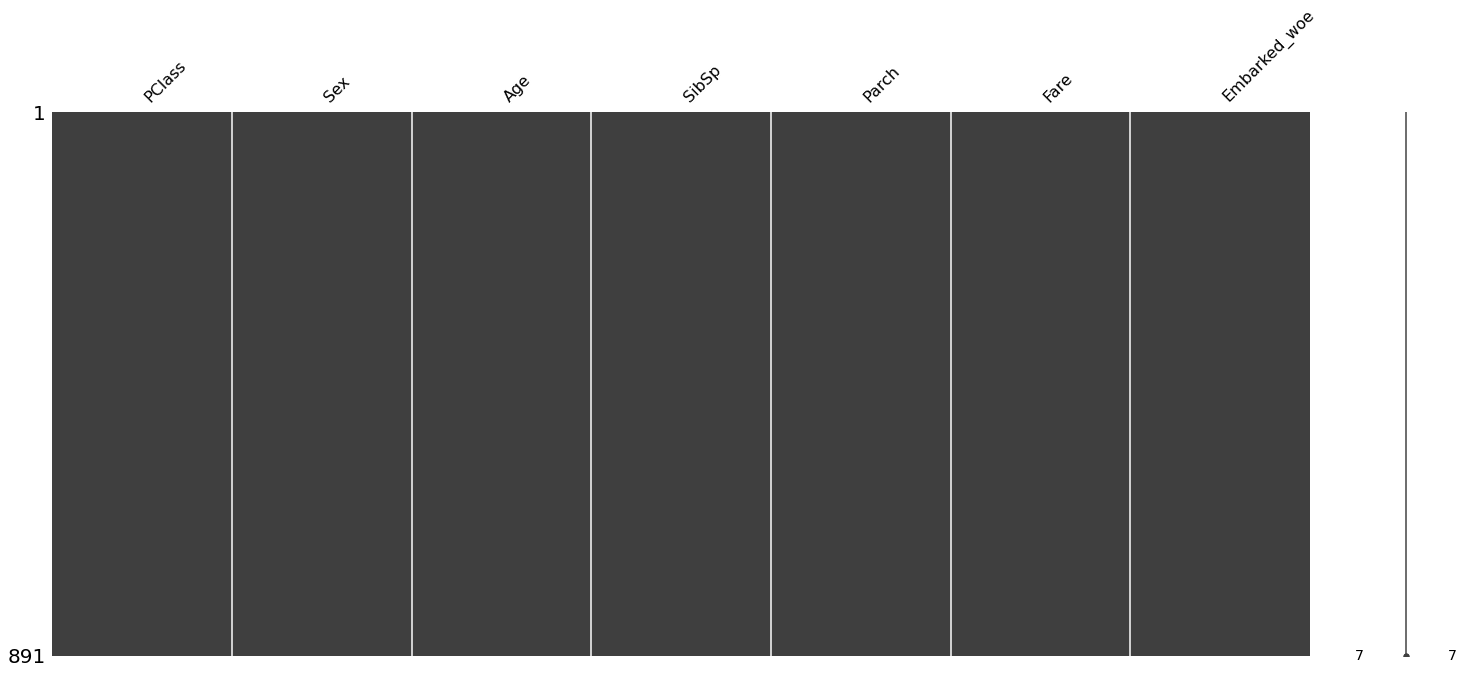

In [66]:
msno.matrix(data_f)

In [67]:
train_missforest["Age"] = data_f["Age"]
train_missforest

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
0,0,3,1,22.000000,1,0,7.2500,S,-0.203535
1,1,1,0,38.000000,1,0,71.2833,C,0.683655
2,1,3,0,26.000000,0,0,7.9250,S,-0.203535
3,1,1,0,35.000000,1,0,53.1000,S,-0.203535
4,0,3,1,35.000000,0,0,8.0500,S,-0.203535
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,S,-0.203535
887,1,1,0,19.000000,0,0,30.0000,S,-0.203535
888,0,3,0,16.268333,1,2,23.4500,S,-0.203535
889,1,1,1,26.000000,0,0,30.0000,C,0.683655


### Getting the training data set ready for the mode

Furthermore we will avoid Data Leak from redoing WOE for each time we split our data from training splitting 

#### Iteration - 1 

In [332]:
train = train_missforest.drop(columns =["Embarked_woe","Survived"], axis = 1)

In [333]:
X, y = train, train_missforest["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 62)

In [334]:
df_X_train  = pd.DataFrame(X_train)

df_y_train = pd.DataFrame(y_train)

df_X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
275,1,0,63.000000,1,0,77.9583,S
351,1,1,51.735500,0,0,35.0000,S
312,2,0,26.000000,1,1,26.0000,S
116,3,1,70.500000,0,0,7.7500,Q
249,2,1,54.000000,1,0,26.0000,S
...,...,...,...,...,...,...,...
267,3,1,25.000000,1,0,7.7750,S
115,3,1,21.000000,0,0,7.9250,S
593,3,0,26.244438,0,2,7.7500,Q
24,3,0,8.000000,3,1,21.0750,S


In [335]:
df_y_train

,Survived
275,1
351,0
312,0
116,0
249,0
...,...
267,1
115,0
593,0
24,0


In [336]:
columns = ["Embarked"]
woe_encoder = ce.WOEEncoder(cols=columns)
woe = woe_encoder.fit(df_X_train[columns], df_y_train['Survived'])
woe_encoded_train = woe_encoder.fit_transform(df_X_train[columns],df_y_train['Survived']).add_suffix('_woe')

df_X_train = df_X_train.join(woe_encoded_train)
df_X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
275,1,0,63.000000,1,0,77.9583,S,-0.190765
351,1,1,51.735500,0,0,35.0000,S,-0.190765
312,2,0,26.000000,1,1,26.0000,S,-0.190765
116,3,1,70.500000,0,0,7.7500,Q,0.101064
249,2,1,54.000000,1,0,26.0000,S,-0.190765
...,...,...,...,...,...,...,...,...
267,3,1,25.000000,1,0,7.7750,S,-0.190765
115,3,1,21.000000,0,0,7.9250,S,-0.190765
593,3,0,26.244438,0,2,7.7500,Q,0.101064
24,3,0,8.000000,3,1,21.0750,S,-0.190765


In [337]:
df_X_train.groupby("Embarked").mean()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
Embarked,,,,,,,
C,1.909774,0.586466,30.892258,0.360902,0.360902,61.054701,0.623571
Q,2.901639,0.540984,27.995531,0.459016,0.131148,13.666669,0.101064
S,2.346228,0.676983,29.840168,0.533849,0.425532,27.457461,-0.190765


#### These above value would be imputed in the Testing set to solve for the Data Leak issue 

In [338]:
def Embarked_woe(value):
    if value == "C":
        return 0.623571
    elif value == "Q":
        return 0.101064
    else:
        return -0.190765

X_test["Embarked_woe"] = X_test["Embarked"].apply(Embarked_woe)

In [339]:
df_X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
275,1,0,63.000000,1,0,77.9583,S,-0.190765
351,1,1,51.735500,0,0,35.0000,S,-0.190765
312,2,0,26.000000,1,1,26.0000,S,-0.190765
116,3,1,70.500000,0,0,7.7500,Q,0.101064
249,2,1,54.000000,1,0,26.0000,S,-0.190765
...,...,...,...,...,...,...,...,...
267,3,1,25.000000,1,0,7.7750,S,-0.190765
115,3,1,21.000000,0,0,7.9250,S,-0.190765
593,3,0,26.244438,0,2,7.7500,Q,0.101064
24,3,0,8.000000,3,1,21.0750,S,-0.190765


In [340]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
204,3,1,18.000000,0,0,8.0500,S,-0.190765
835,1,0,39.000000,1,1,83.1583,C,0.623571
291,1,0,19.000000,1,0,91.0792,C,0.623571
78,2,1,0.830000,0,2,29.0000,S,-0.190765
472,2,0,33.000000,1,2,27.7500,S,-0.190765
...,...,...,...,...,...,...,...,...
390,1,1,36.000000,1,2,120.0000,S,-0.190765
494,3,1,21.000000,0,0,8.0500,S,-0.190765
62,1,1,45.000000,1,0,83.4750,S,-0.190765
863,3,0,13.734381,8,2,69.5500,S,-0.190765


In [341]:
X_train = df_X_train.drop(["Embarked"], axis = 1)
X_test = X_test.drop(["Embarked"], axis = 1)

In [342]:
X_train.dtypes

Pclass            int64
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Embarked_woe    float64
dtype: object

In [343]:
X_test.dtypes

Pclass            int64
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Embarked_woe    float64
dtype: object

In [345]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [347]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth= 7,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 eval_metric = ['error','auc'],
 nthread=4,
 scale_pos_weight=0.6229,
 predictor = "gpu_predictor"
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=10)

[0]	validation_0-error:0.13202	validation_0-auc:0.87530	validation_1-error:0.20670	validation_1-auc:0.87280
[1]	validation_0-error:0.13202	validation_0-auc:0.87558	validation_1-error:0.20670	validation_1-auc:0.87185
[2]	validation_0-error:0.13343	validation_0-auc:0.88572	validation_1-error:0.20670	validation_1-auc:0.87726
[3]	validation_0-error:0.12640	validation_0-auc:0.89860	validation_1-error:0.18994	validation_1-auc:0.88445
[4]	validation_0-error:0.12921	validation_0-auc:0.90144	validation_1-error:0.19553	validation_1-auc:0.88375
[5]	validation_0-error:0.12360	validation_0-auc:0.90160	validation_1-error:0.18436	validation_1-auc:0.88687
[6]	validation_0-error:0.11938	validation_0-auc:0.90486	validation_1-error:0.17877	validation_1-auc:0.88382
[7]	validation_0-error:0.12360	validation_0-auc:0.90610	validation_1-error:0.18436	validation_1-auc:0.88191
[8]	validation_0-error:0.12079	validation_0-auc:0.90708	validation_1-error:0.17877	validation_1-auc:0.88204
[9]	validation_0-error:0.120

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'auc'], gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.6229, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [348]:
y_predicted = model.predict(X_test)

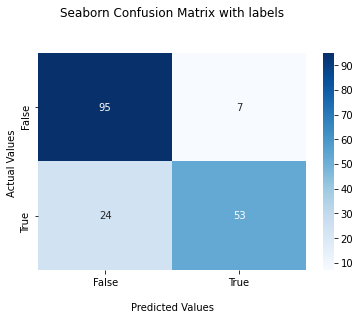

In [349]:
cf_matrix = confusion_matrix(y_test,y_predicted)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

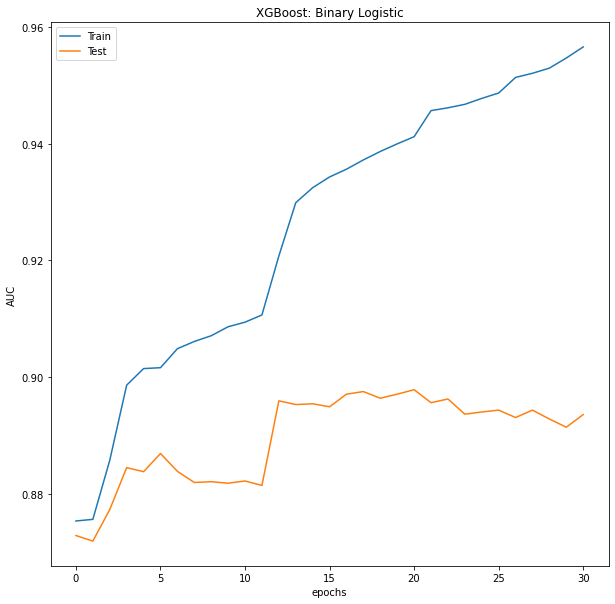

In [350]:
results = model.evals_result()
epochs = len(results['validation_1']['auc'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.xlabel("epochs")
pyplot.title('XGBoost: Binary Logistic')
pyplot.show()

In [351]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
204,3,1,18.000000,0,0,8.0500,-0.190765
835,1,0,39.000000,1,1,83.1583,0.623571
291,1,0,19.000000,1,0,91.0792,0.623571
78,2,1,0.830000,0,2,29.0000,-0.190765
472,2,0,33.000000,1,2,27.7500,-0.190765
...,...,...,...,...,...,...,...
390,1,1,36.000000,1,2,120.0000,-0.190765
494,3,1,21.000000,0,0,8.0500,-0.190765
62,1,1,45.000000,1,0,83.4750,-0.190765
863,3,0,13.734381,8,2,69.5500,-0.190765


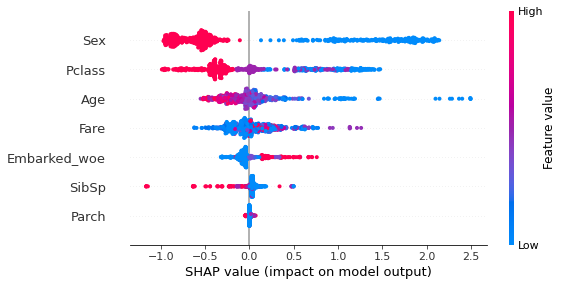

In [352]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [98]:
validation = test
validation

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [137]:
validation = test.drop(["PassengerId","Name","Ticket","Cabin"], axis = 1)

In [138]:
validation["Embarked_woe"] = validation["Embarked"].apply(Embarked_woe)

In [140]:
validation = validation.drop(["Embarked"], axis = 1)

In [142]:
validation["Sex"] = validation["Sex"].apply(Sex)

In [143]:
validation

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
0,3,1,34.5,0,0,7.8292,0.033241
1,3,0,47.0,1,0,7.0000,-0.184298
2,2,1,62.0,0,0,9.6875,0.033241
3,3,1,27.0,0,0,8.6625,-0.184298
4,3,0,22.0,1,1,12.2875,-0.184298
...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,-0.184298
414,1,0,39.0,0,0,108.9000,0.647251
415,3,1,38.5,0,0,7.2500,-0.184298
416,3,1,NaN,0,0,8.0500,-0.184298


In [151]:
imputer = MissForest()
fill = imputer.fit_transform(validation,cat_vars = [0,1,3,4,6])

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which 

Iteration: 0


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



Iteration: 1


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



Iteration: 2


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



Iteration: 3


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\venka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



Iteration: 4
Iteration: 5


C:\Users\venka\anaconda3\lib\site-packages\missingpy\missforest.py:406: RuntimeWarning:

invalid value encountered in long_scalars



In [152]:
validation_f = pd.DataFrame(fill, columns =["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked_woe"])
validation_f

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe
0,3.0,1.0,34.500000,0.0,0.0,7.8292,0.033241
1,3.0,0.0,47.000000,1.0,0.0,7.0000,-0.184298
2,2.0,1.0,62.000000,0.0,0.0,9.6875,0.033241
3,3.0,1.0,27.000000,0.0,0.0,8.6625,-0.184298
4,3.0,0.0,22.000000,1.0,1.0,12.2875,-0.184298
...,...,...,...,...,...,...,...
413,3.0,1.0,26.356321,0.0,0.0,8.0500,-0.184298
414,1.0,0.0,39.000000,0.0,0.0,108.9000,0.647251
415,3.0,1.0,38.500000,0.0,0.0,7.2500,-0.184298
416,3.0,1.0,26.356321,0.0,0.0,8.0500,-0.184298


In [153]:
y_vlad = model.predict(validation_f)

In [154]:
y_vlad

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [155]:
output= pd.DataFrame()
output["PassengerId"] = test["PassengerId"]
output["Survived"] = y_vlad

In [156]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [158]:
output.to_csv("output_titatic.csv")

# Attempt 1 score : - Score: 0.75119

### Attempt 2 ( Oversampling)

In [232]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.000000,1,0,7.2500,S
1,1,0,38.000000,1,0,71.2833,C
2,3,0,26.000000,0,0,7.9250,S
3,1,0,35.000000,1,0,53.1000,S
4,3,1,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,S
887,1,0,19.000000,0,0,30.0000,S
888,3,0,16.268333,1,2,23.4500,S
889,1,1,26.000000,0,0,30.0000,C


In [233]:
train_missforest

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_woe
0,0,3,1,22.000000,1,0,7.2500,S,-0.203535
1,1,1,0,38.000000,1,0,71.2833,C,0.683655
2,1,3,0,26.000000,0,0,7.9250,S,-0.203535
3,1,1,0,35.000000,1,0,53.1000,S,-0.203535
4,0,3,1,35.000000,0,0,8.0500,S,-0.203535
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,S,-0.203535
887,1,1,0,19.000000,0,0,30.0000,S,-0.203535
888,0,3,0,16.268333,1,2,23.4500,S,-0.203535
889,1,1,1,26.000000,0,0,30.0000,C,0.683655


In [238]:
train = train_missforest.drop(["Survived","Embarked"], axis = 1)

In [239]:
ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(train,train_missforest["Survived"])

In [240]:
data_oversampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

In [241]:
data_oversampled

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_woe,Survived
0,3,1,22.000000,1,0,7.250000,-0.203535,0
1,1,0,38.000000,1,0,71.283300,0.683655,1
2,3,0,26.000000,0,0,7.925000,-0.203535,1
3,1,0,35.000000,1,0,53.100000,-0.203535,1
4,3,1,35.000000,0,0,8.050000,-0.203535,0
...,...,...,...,...,...,...,...,...
1103,1,0,48.262634,1,0,55.316213,0.356563,1
1104,2,0,28.299513,1,0,24.599025,0.417930,1
1105,1,0,58.936398,0,1,80.252514,0.683655,1
1106,2,0,24.014617,0,0,26.000000,-0.203535,1


<AxesSubplot:xlabel='Survived', ylabel='count'>

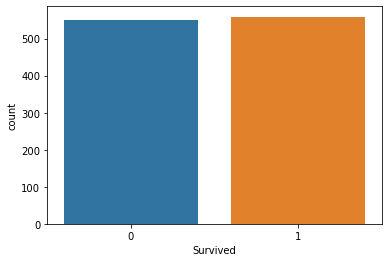

In [244]:
sns.countplot(x = "Survived",data = data_oversampled)

<AxesSubplot:xlabel='Survived', ylabel='count'>

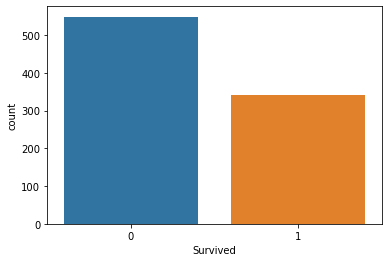

In [245]:
sns.countplot(x = "Survived",data = train_missforest)


In [269]:
train = data_oversampled.drop(["Survived","Embarked_woe"], axis = 1)
X, y = train, data_oversampled["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 62)

In [288]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth= 4,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 eval_metric = ['error','auc'],
 nthread=1,
 scale_pos_weight=1,
 predictor = "gpu_predictor"
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=10)

[0]	validation_0-error:0.15484	validation_0-auc:0.89222	validation_1-error:0.18018	validation_1-auc:0.86963
[1]	validation_0-error:0.15484	validation_0-auc:0.89360	validation_1-error:0.18018	validation_1-auc:0.87445
[2]	validation_0-error:0.15484	validation_0-auc:0.89477	validation_1-error:0.18018	validation_1-auc:0.87391
[3]	validation_0-error:0.15097	validation_0-auc:0.89685	validation_1-error:0.18619	validation_1-auc:0.87515
[4]	validation_0-error:0.15097	validation_0-auc:0.89963	validation_1-error:0.18619	validation_1-auc:0.87160
[5]	validation_0-error:0.14839	validation_0-auc:0.90525	validation_1-error:0.18619	validation_1-auc:0.87593
[6]	validation_0-error:0.14968	validation_0-auc:0.90526	validation_1-error:0.18619	validation_1-auc:0.87643
[7]	validation_0-error:0.14839	validation_0-auc:0.90741	validation_1-error:0.18619	validation_1-auc:0.87604
[8]	validation_0-error:0.14839	validation_0-auc:0.90916	validation_1-error:0.18619	validation_1-auc:0.86846
[9]	validation_0-error:0.148

C:\Users\venka\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[11]	validation_0-error:0.14710	validation_0-auc:0.91716	validation_1-error:0.18619	validation_1-auc:0.88255
[12]	validation_0-error:0.14710	validation_0-auc:0.91700	validation_1-error:0.18619	validation_1-auc:0.88212
[13]	validation_0-error:0.14710	validation_0-auc:0.92010	validation_1-error:0.18619	validation_1-auc:0.88425
[14]	validation_0-error:0.14839	validation_0-auc:0.92131	validation_1-error:0.18619	validation_1-auc:0.88648
[15]	validation_0-error:0.14839	validation_0-auc:0.92235	validation_1-error:0.18619	validation_1-auc:0.88807
[16]	validation_0-error:0.14323	validation_0-auc:0.92365	validation_1-error:0.18619	validation_1-auc:0.88778
[17]	validation_0-error:0.14452	validation_0-auc:0.92859	validation_1-error:0.17718	validation_1-auc:0.89163
[18]	validation_0-error:0.14064	validation_0-auc:0.92901	validation_1-error:0.18018	validation_1-auc:0.89190
[19]	validation_0-error:0.14581	validation_0-auc:0.93048	validation_1-error:0.17417	validation_1-auc:0.89515
[20]	validation_0-e

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'auc'], gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

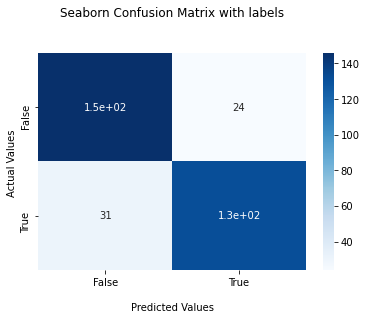

In [289]:
y_predicted = model.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_predicted)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

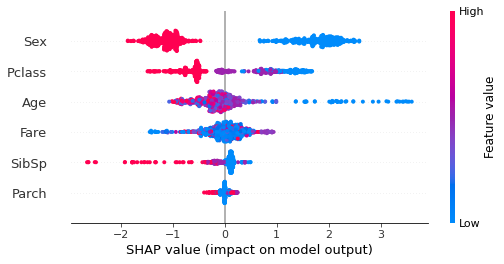

In [290]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

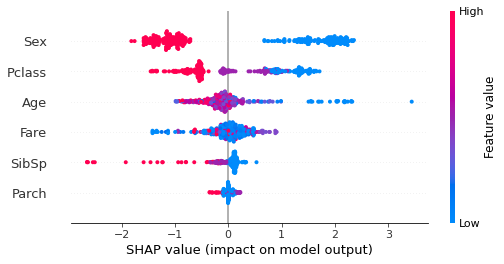

In [291]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [292]:
validation_f1 = validation_f.drop(["Embarked_woe"], axis = 1)
y_vlad = model.predict(validation_f1)
output= pd.DataFrame()
output["PassengerId"] = test["PassengerId"]
output["Survived"] = y_vlad

In [293]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [287]:
output.to_csv("output_titatic2.csv",index = False)


# Attempt 2 score : - Score: 0.78229

In [294]:
data_oversampled["Age"]

0       22.000000
1       38.000000
2       26.000000
3       35.000000
4       35.000000
          ...    
1103    48.262634
1104    28.299513
1105    58.936398
1106    24.014617
1107    25.244189
Name: Age, Length: 1108, dtype: float64

In [295]:
data_oversampled["Fare"]

0        7.250000
1       71.283300
2        7.925000
3       53.100000
4        8.050000
          ...    
1103    55.316213
1104    24.599025
1105    80.252514
1106    26.000000
1107    26.976758
Name: Fare, Length: 1108, dtype: float64

C:\Users\venka\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Age', ylabel='Density'>

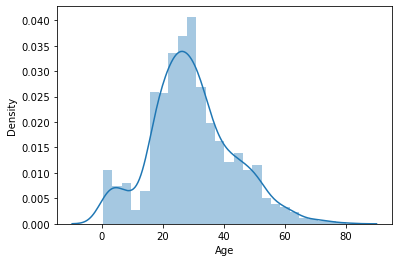

In [299]:
sns.distplot(data_oversampled["Age"])

C:\Users\venka\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Fare', ylabel='Density'>

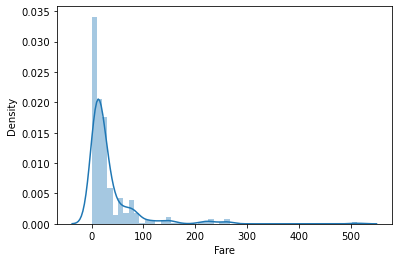

In [300]:
sns.distplot(data_oversampled["Fare"])

In [356]:
def Age_Ordinal(value):
    if value < 20 :
        return 1
    elif value >= 20 and value < 40:
        return 2 
    elif value >= 40 and value < 60:
        return 3
    else:
        return 4

def Fare_Ordinal(value):
    if value < 50 :
        return 1
    elif value >= 50 and value < 100:
        return 2 
    else:
        return 3

In [357]:
Att_3 = pd.DataFrame()
Att_3["Age"] = data_oversampled["Age"].apply(Age_Ordinal)
Att_3["Fare"] = data_oversampled["Fare"].apply(Fare_Ordinal)

<AxesSubplot:xlabel='Age', ylabel='count'>

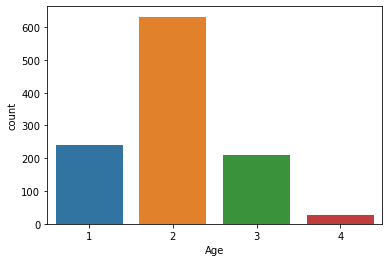

In [358]:
sns.countplot(x = "Age", data =Att_3)

<AxesSubplot:xlabel='Fare', ylabel='count'>

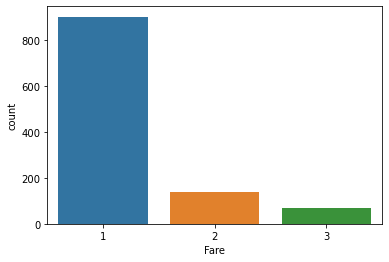

In [359]:
sns.countplot(x = "Fare", data =Att_3)

In [403]:
train = data_oversampled.drop(["Survived","Embarked_woe"], axis = 1)
#train["Age_B"] = Att_3["Age"]
#train["Fare_B"] = Att_3["Fare"]
X, y = train, data_oversampled["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)

In [404]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare
244,3,1,30.000000,0,0,7.225000
1049,3,0,23.267676,0,0,7.741301
446,2,0,13.000000,0,1,19.500000
935,3,0,15.926753,0,0,7.570329
722,2,1,34.000000,0,0,13.000000
...,...,...,...,...,...,...
919,3,1,29.888950,0,0,7.773158
211,2,0,35.000000,0,0,21.000000
502,3,0,18.374369,0,0,7.629200
537,1,0,30.000000,0,0,106.425000


In [405]:
model = XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth= 10,
 min_child_weight=1,
 gamma= 1,
 num_boost_round = 1,
 subsample=0.8,
 colsample_bytree=0.8,
 colsample_bynode = 0.8,
 objective= 'reg:logistic',
 eval_metric = ['error','auc'],
 nthread=1,
 predictor = "gpu_predictor",
 num_parallel_tree = 100,
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=100)

[19:57:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.10497	validation_0-auc:0.94291	validation_1-error:0.17117	validation_1-auc:0.90873
[1]	validation_0-error:0.10497	validation_0-auc:0.94506	validation_1-error:0.17117	validation_1-auc:0.90727
[2]	validation_0-error:0.10609	validation_0-auc:0.94912	validation_1-error:0.17568	validation_1-auc:0.90922


C:\Users\venka\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[3]	validation_0-error:0.10497	validation_0-auc:0.95271	validation_1-error:0.17117	validation_1-auc:0.91020
[4]	validation_0-error:0.10271	validation_0-auc:0.95577	validation_1-error:0.17568	validation_1-auc:0.91020
[5]	validation_0-error:0.10158	validation_0-auc:0.95855	validation_1-error:0.18018	validation_1-auc:0.91085
[6]	validation_0-error:0.10045	validation_0-auc:0.96048	validation_1-error:0.16216	validation_1-auc:0.91159
[7]	validation_0-error:0.10045	validation_0-auc:0.96219	validation_1-error:0.16216	validation_1-auc:0.91232
[8]	validation_0-error:0.09706	validation_0-auc:0.96389	validation_1-error:0.16667	validation_1-auc:0.91175
[9]	validation_0-error:0.09368	validation_0-auc:0.96580	validation_1-error:0.17117	validation_1-auc:0.91183
[10]	validation_0-error:0.09481	validation_0-auc:0.96743	validation_1-error:0.16216	validation_1-auc:0.91110
[11]	validation_0-error:0.09368	validation_0-auc:0.96882	validation_1-error:0.16667	validation_1-auc:0.91028
[12]	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.8, colsample_bytree=0.8,
              eval_metric=['error', 'auc'], gamma=1, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=1, nthread=1, num_boost_round=1,
              num_parallel_tree=100, objective='reg:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...)

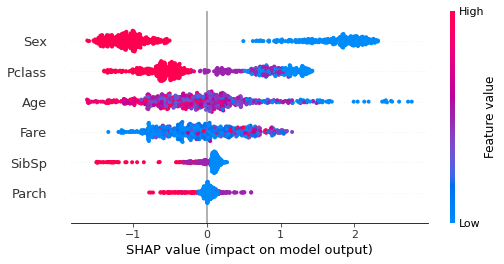

In [398]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [406]:
validation_f1 = validation_f.drop(["Embarked_woe"], axis = 1)
y_vlad = model.predict(validation_f1)
output= pd.DataFrame()
output["PassengerId"] = test["PassengerId"]
output["Survived"] = y_vlad

In [407]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [401]:
output.to_csv("Output8.csv", index = False)

In [409]:
train = pd.read_csv("train (3).csv")
titles = set()
for name in train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
print(titles)

{'Mrs', 'Jonkheer', 'Don', 'Rev', 'Mr', 'Dr', 'Major', 'the Countess', 'Col', 'Master', 'Mme', 'Lady', 'Capt', 'Miss', 'Sir', 'Mlle', 'Ms'}


In [ ]:
Title_Dictionary = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty","Don": "Royalty","Sir" : "Royalty",
                    "Dr": "Officer","Rev": "Officer","the Countess":"Royalty",
                    "Mme": "Mrs","Mlle": "Miss","Ms": "Mrs","Mr" : "Mr","Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}